# Imports

In [109]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

from shapely.geometry.polygon import LinearRing
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import json

import cdsapi
c = cdsapi.Client()

# functions

In [108]:
import numpy as np
from skimage.draw import polygon as skpolygon

def find_nearest(lons,lats,xlon,xlat):
    dist=( (lats-xlat)**2 +(lons-xlon)**2 )
    sidx=np.unravel_index(dist.argmin(),dist.shape) 
    return sidx,dist[sidx[0],sidx[1]]

def use_polygon(lons,lats,polygon):
    '''
    lons: 2d field of longitudes (e.g. from satellite swath or np.meshgrid(lon,lat))
    lats: 2d field of latitudes  (see above)
    poly: array [[lon0,lat0],[lon1,lat1],...], at least three corner points
    '''
    polg=[]
    for p in polygon:
        polg.append(find_nearest(lons,lats,p[0],p[1])[0])
    
    polg=np.array(polg)
    mask = np.zeros(lons.shape, dtype=np.uint8)
    r,c = polg[:,0], polg[:,1]
    rr, cc = skpolygon(r, c)
    mask[rr, cc] = 1
    return mask.astype(bool)

# Download ERA data with CDS

## reanalysis-era5-single-levels-monthly-means

In [257]:
#!/usr/bin/env python
import cdsapi
 
c = cdsapi.Client()
 
c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'reanalysis',
        'variable': '2m_temperature',
        'year': [
            '1994','1995', '1996', '1997', '1998', '1999', '2000',
            '2001','2002', '2003', '2004', '2005', '2006', '2007', 
            '2008','2009', '2010', '2011', '2012', '2013', '2014', 
            '2015', '2016', '2017', '2018', '2019', '2020'
                ] ,
        'month': [
                '01', '02', '03', '04', '05', '06',
                '07', '08', '09', '10', '11', '12'
                ],
        'time': '12:00',
        'format': 'netcdf',                 # Supported format: grib and netcdf. Default: grib
        'area'          : [75, -180, 40, 180], # North, West, South, East.          Default: global
        'grid'          : [1.0, 1.0],       # Latitude/longitude grid.           Default: 0.25 x 0.25
    },
    'era5_monthly_1994-2020_temp2m_NorthOf40deg.nc')         # Output file. Adapt as you wish.

2021-02-09 18:46:39,100 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2021-02-09 18:46:39,267 INFO Request is queued
2021-02-09 18:46:40,303 INFO Request is running
2021-02-09 18:48:33,058 INFO Request is completed
2021-02-09 18:48:33,058 INFO Downloading https://download-0014.copernicus-climate.eu/cache-compute-0014/cache/data7/adaptor.mars.internal-1612892799.383369-21596-11-555d47d9-1a1b-4a4c-b5d3-0d5b36a2e218.nc to era5_monthly_1994-2020_temp2m_NorthOf40deg.nc (16M)
2021-02-09 18:48:34,882 INFO Download rate 8.8M/s   


Result(content_length=16800208,content_type=application/x-netcdf,location=https://download-0014.copernicus-climate.eu/cache-compute-0014/cache/data7/adaptor.mars.internal-1612892799.383369-21596-11-555d47d9-1a1b-4a4c-b5d3-0d5b36a2e218.nc)

## reanalysis-era5-land

In [256]:
#!/usr/bin/env python
import cdsapi
 
c = cdsapi.Client()
 
c.retrieve(
    'reanalysis-era5-single-levels-hourly-means',
    {
        'product_type': 'reanalysis',
        'variable': '2m_temperature',
        'year': [
            '1994','1995', '1996', '1997', '1998', '1999', '2000',
            '2001','2002', '2003', '2004', '2005', '2006', '2007', 
            '2008','2009', '2010', '2011', '2012', '2013', '2014', 
            '2015', '2016', '2017', '2018', '2019', '2020'
                ] ,
        'month': [
                '01', '02', '03', '04', '05', '06',
                '07', '08', '09', '10', '11', '12'
                ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'format': 'netcdf',                 # Supported format: grib and netcdf. Default: grib
        'area'          : [75, -180, 40, 180], # North, West, South, East.          Default: global
        'grid'          : [1.0, 1.0],       # Latitude/longitude grid.           Default: 0.25 x 0.25
    },
    'era5_hourly_1994-2020_temp2m_NorthOf40deg.nc.nc')         # Output file. Adapt as you wish.

2021-02-09 18:40:57,509 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2021-02-09 18:40:57,960 INFO Request is queued
2021-02-09 18:40:58,999 INFO Request is running


KeyboardInterrupt: 

# Read nc file and variables

In [258]:
DATA_PATH = "/all_mounts/masp26/SMOS_artic/BennetProjects/LenaLaptev/_notebooksBennet/" # "/Users"
INFILE = "era5_monthly_1994-2020_temp2m_NorthOf40deg.nc" # replace with your file


nc_data = nc.Dataset(os.path.join(DATA_PATH, INFILE))
nc_time_var = nc_data.variables['time']
#nc_time_var.ncattrs()
cal = nc_time_var.getncattr('calendar')
date_units = nc_time_var.getncattr('units')
dtime = nc.num2date(nc_time_var[:],date_units,calendar=cal, only_use_cftime_datetimes=False)

print(nc_data.variables)

nc_temp1000_var = nc_data.variables['t2m']

tempdeg = nc_temp1000_var[:,0,:,:].data-273.15

lat_var = nc_data.variables['latitude'][:]
lon_var = nc_data.variables['longitude'][:]

OrderedDict([('longitude', <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used), ('latitude', <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (36,)
filling on, default _FillValue of 9.969209968386869e+36 used), ('expver', <class 'netCDF4._netCDF4.Variable'>
int32 expver(expver)
    long_name: expver
unlimited dimensions: 
current shape = (2,)
filling on, default _FillValue of -2147483647 used), ('time', <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (324,)
filling on, default _FillValue of -2147483647 used), ('t2m', <class 'netCDF4._netCDF4.Variable'>
int16 t2m(time, expver, latitude, lo

# QuickPlot of whole nc

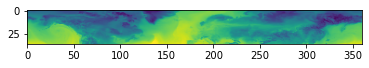

In [197]:
plt.imshow(tempdeg[0]);


# Extract data on simple Polygon

In [158]:
####define multipolygon
PolyLaptev = [[110,55],[105,70],[120,74],[123,71],[129,60],[125,51]]

lon,lat = np.meshgrid(lon_var,lat_var)
TExtr = use_polygon(lon, lat,PolyLaptev)

In [173]:
lon,lat = np.meshgrid(lon_var,lat_var)
TExtr = use_polygon(lon, lat,Kolyma_coords)

# Read Catchments from geojson

In [216]:
pathCatchments = "/all_mounts/masp17/bjuhls/bjuhls_massp17/LenaLaptevSea/vectordata/ArcticRiverCatchments/LargeArcticRivers/"

Kolyma = "Kolyma.geojson"
Yukon = "Yukon.geojson"
Mackenzie = "Mackenzie.geojson"
Ob = "Ob.geojson"
Yenisei = "Yenisei_2.geojson"
Lena = "Lena.geojson"

with open(os.path.join(pathCatchments, Kolyma)) as f:
    data = json.load(f)   
for feature in data['features']:
    Kolyma_coords = feature['geometry']['coordinates'][0]
    
with open(os.path.join(pathCatchments, Yukon)) as f:
    data = json.load(f)   
for feature in data['features']:
    Yukon_coords = feature['geometry']['coordinates'][0]
    
with open(os.path.join(pathCatchments, Mackenzie)) as f:
    data = json.load(f)   
for feature in data['features']:
    Mackenzie_coords = feature['geometry']['coordinates'][0]
    
with open(os.path.join(pathCatchments, Ob)) as f:
    data = json.load(f)   
for feature in data['features']:
    Ob_coords = feature['geometry']['coordinates'][0]
    
with open(os.path.join(pathCatchments, Yenisei)) as f:
    data = json.load(f)   
for feature in data['features']:
    Yenisei_coords = feature['geometry']['coordinates'][0]
    
with open(os.path.join(pathCatchments, Lena)) as f:
    data = json.load(f)   
for feature in data['features']:
    Lena_coords = feature['geometry']['coordinates'][0]
    


# Create Masks for Rivers

In [219]:
lon,lat = np.meshgrid(lon_var,lat_var)

Mask_Kolyma = use_polygon(lon, lat,Kolyma_coords)
Mask_Yukon = use_polygon(lon, lat,Yukon_coords[0])
Mask_Mackenzie = use_polygon(lon, lat,Mackenzie_coords)
Mask_Ob = use_polygon(lon, lat,Ob_coords)
Mask_Yenisei = use_polygon(lon, lat,Yenisei_coords[0])
Mask_Lena = use_polygon(lon, lat,Lena_coords)#

# Map extracted data

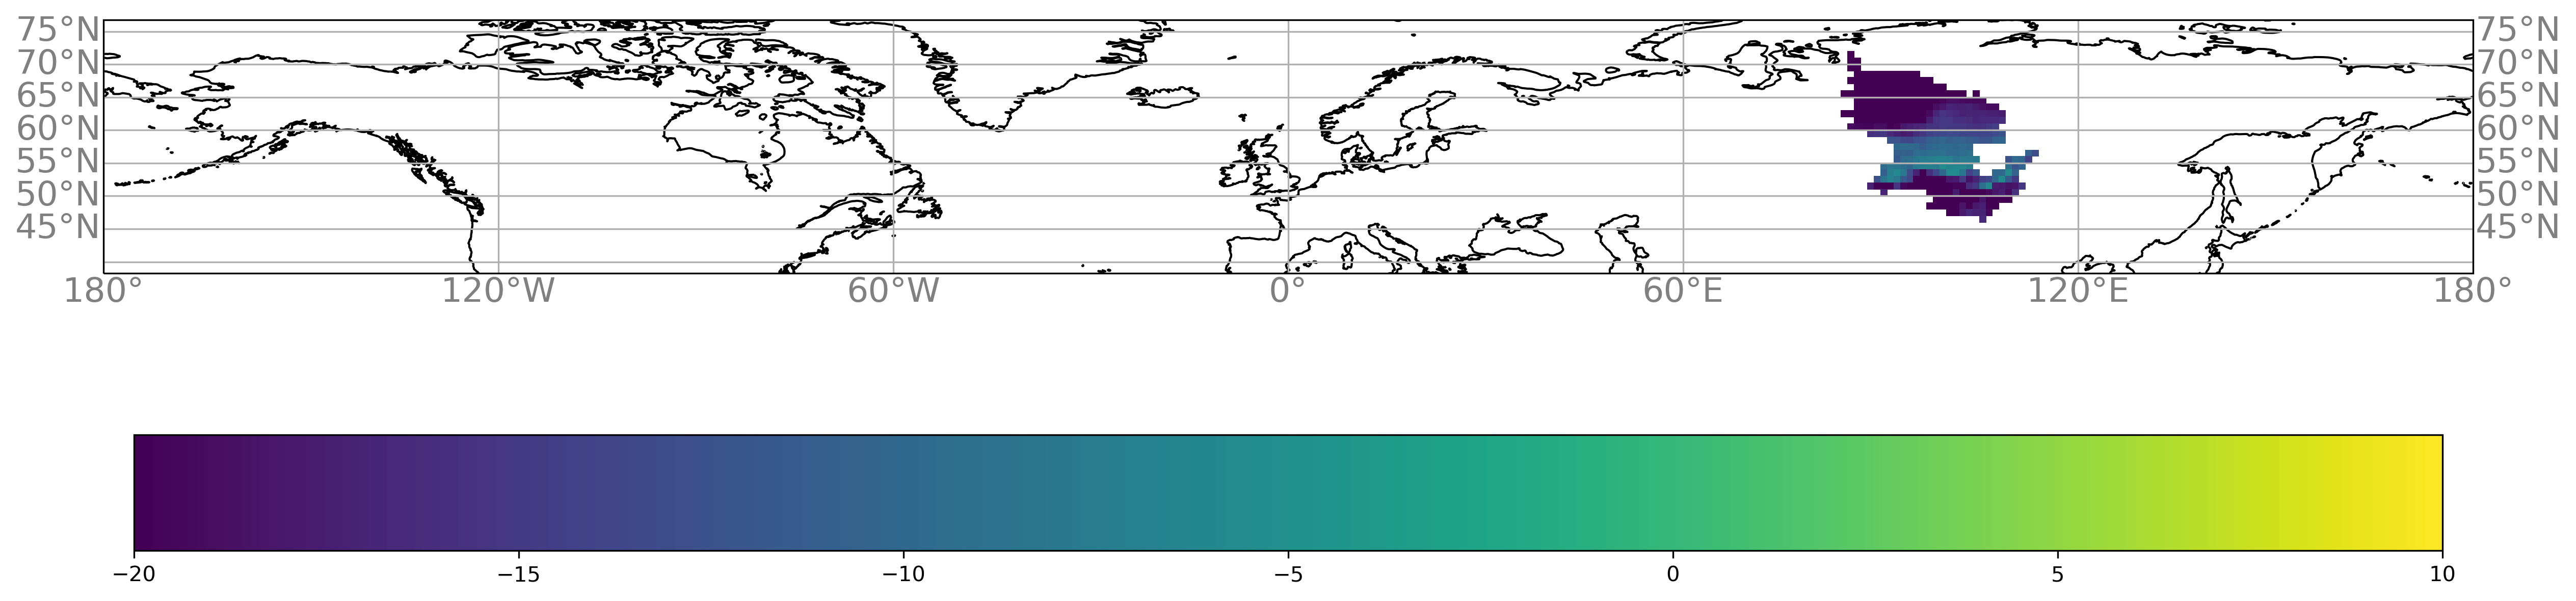

In [220]:
land_resolution = '50m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', land_resolution,
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

fig1 = plt.figure(figsize=(20, 20), dpi=300)

m = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.0))
#m.add_feature(land_poly)


f1 = plt.pcolormesh(lon,lat, np.where(Mask_Yenisei, tempdeg[0],np.nan), shading='flat', 
                    vmin=-20, vmax=10, cmap=plt.cm.viridis)

m.coastlines(resolution=land_resolution, color='black', linewidth=1)

g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07, 
                    ) 
#cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','50'], fontsize=20) 
#cbar.set_label('Chlorophyll, mg.m$^{-3}$', fontsize=20)
#plt.title('OLCI [CHL_NN] mg.m$^{-3}$', fontsize=20);
plt.show()

# Extract  & Plot time series

In [259]:
TempMean_Yenisei = []
TempMean_Yukon = []
TempMean_Ob = []
TempMean_Mackenzie = []
TempMean_Lena = []
TempMean_Kolyma = []

for i, e in enumerate(tempdeg):
    TempMean_Yenisei.append(np.nanmean(tempdeg[i,:,:][Mask_Yenisei]))
    TempMean_Yukon.append(np.nanmean(tempdeg[i,:,:][Mask_Yukon]))
    TempMean_Ob.append(np.nanmean(tempdeg[i,:,:][Mask_Ob]))
    TempMean_Mackenzie.append(np.nanmean(tempdeg[i,:,:][Mask_Mackenzie]))
    TempMean_Lena.append(np.nanmean(tempdeg[i,:,:][Mask_Lena]))
    TempMean_Kolyma.append(np.nanmean(tempdeg[i,:,:][Mask_Kolyma]))

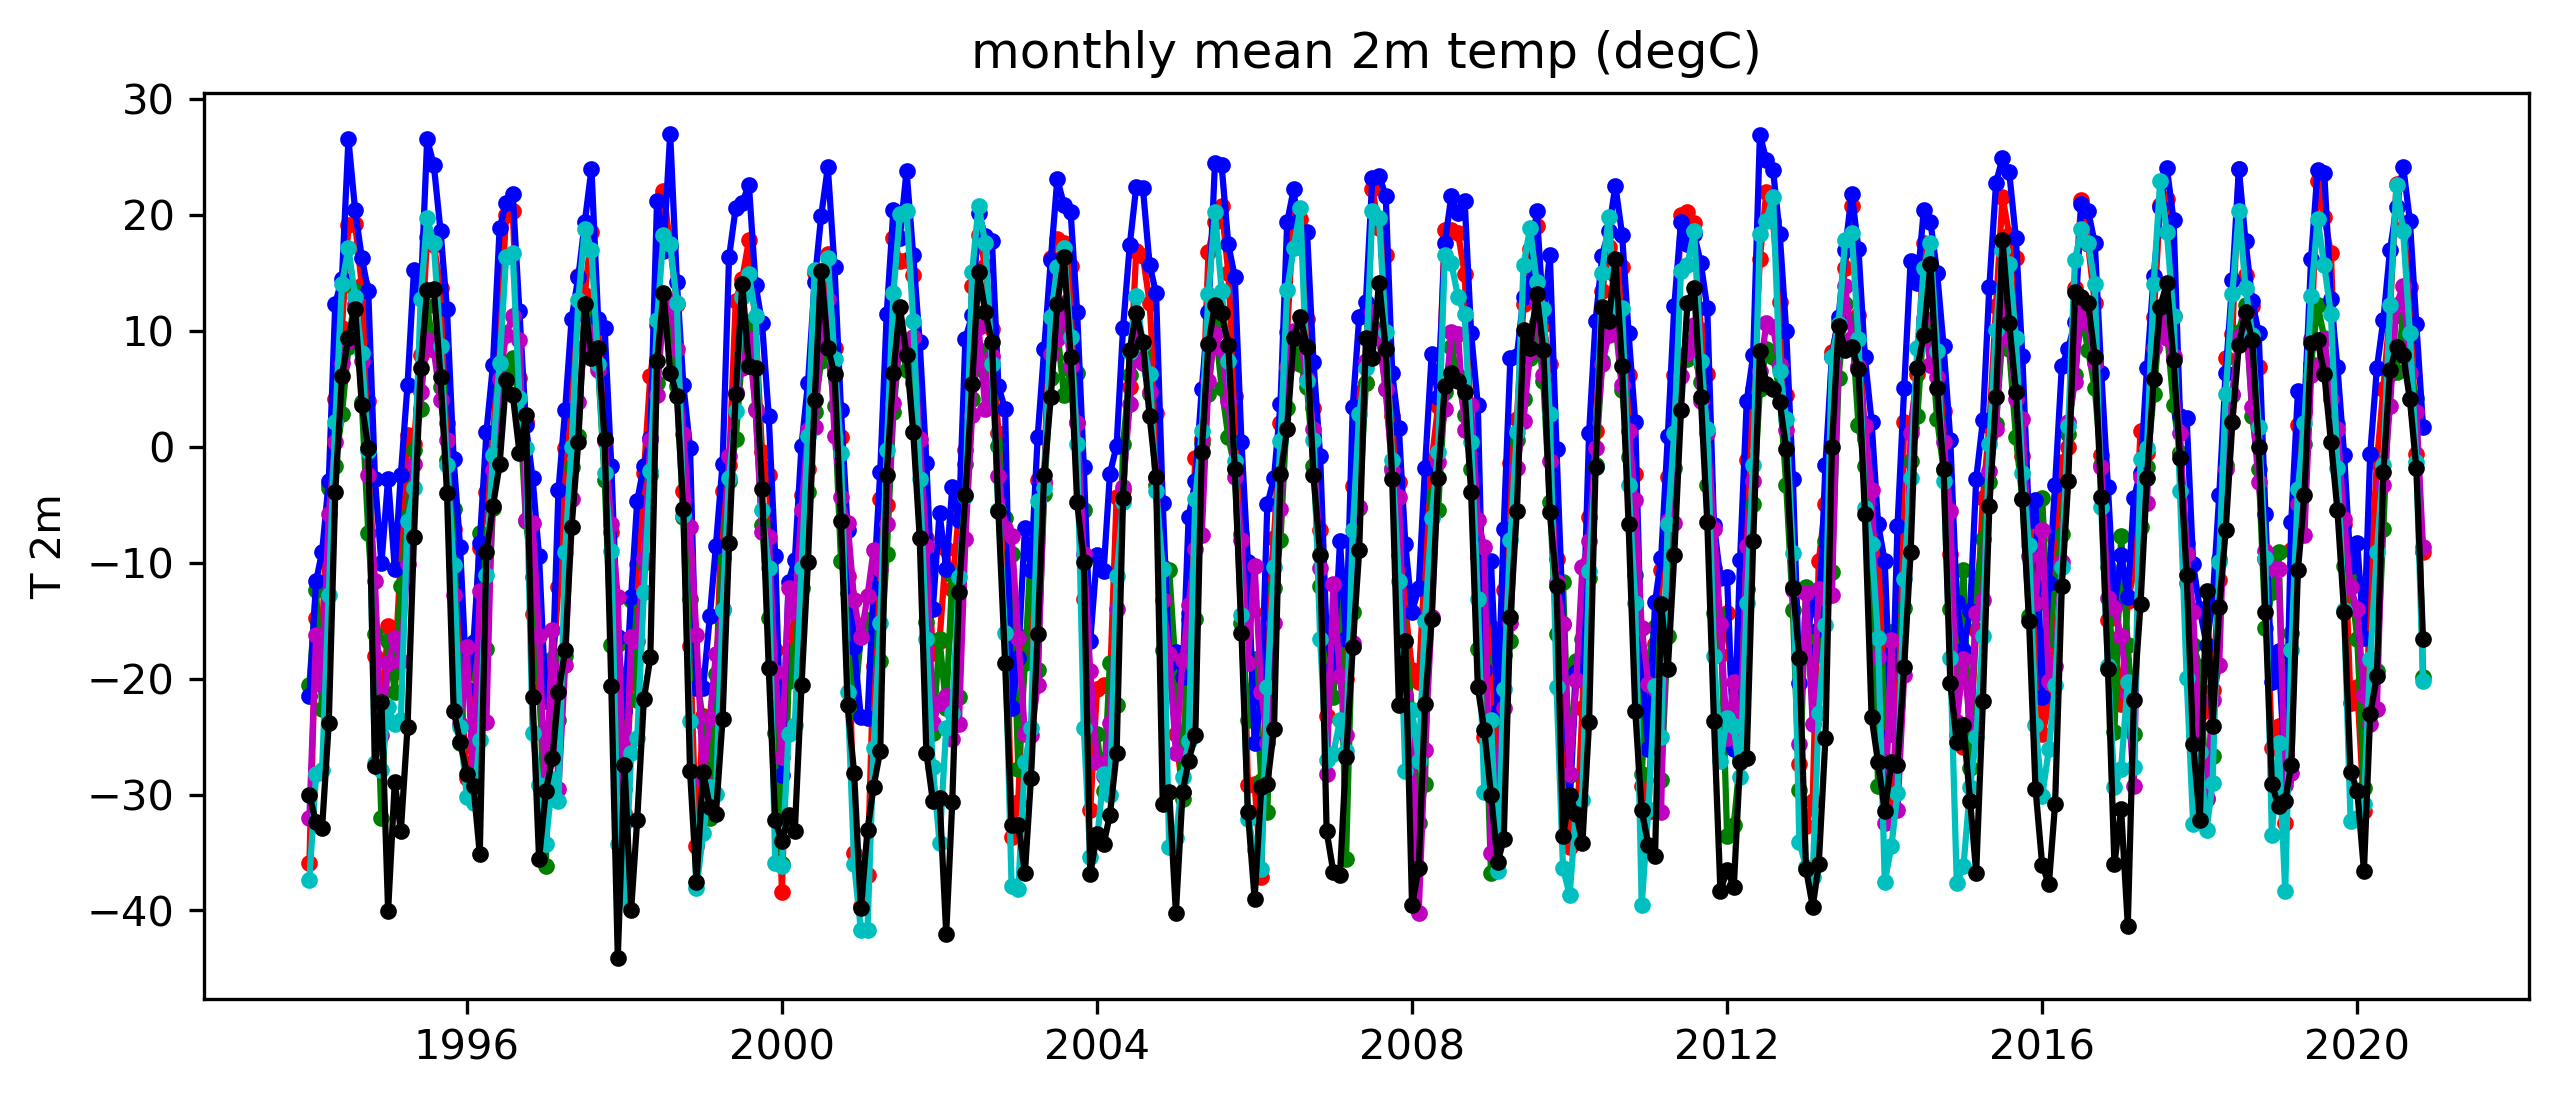

In [260]:
f, ((ax1 )) = plt.subplots(1, 1,figsize=(10,4), dpi=300,sharex =True)

plt.title("monthly mean 2m temp (degC)")

ax1.plot(dtime[:-1],TempMean_Yenisei[:-1], "r.-")
ax1.plot(dtime[:-1],TempMean_Yukon[:-1], "g.-")
ax1.plot(dtime[:-1],TempMean_Ob[:-1], "b.-")
ax1.plot(dtime[:-1],TempMean_Mackenzie[:-1], "m.-")
ax1.plot(dtime[:-1],TempMean_Lena[:-1], "c.-")
ax1.plot(dtime[:-1],TempMean_Kolyma[:-1], "k.-")

plt.ylabel("T 2m")
plt.show()

# Create means of first decade

In [296]:
Yenisei_Jan = TempMean_Yenisei[0::12]
Yenisei_Feb = TempMean_Yenisei[1::12]
Yenisei_June = TempMean_Yenisei[5::12]

Yenisei_Aug = TempMean_Yenisei[7::12]

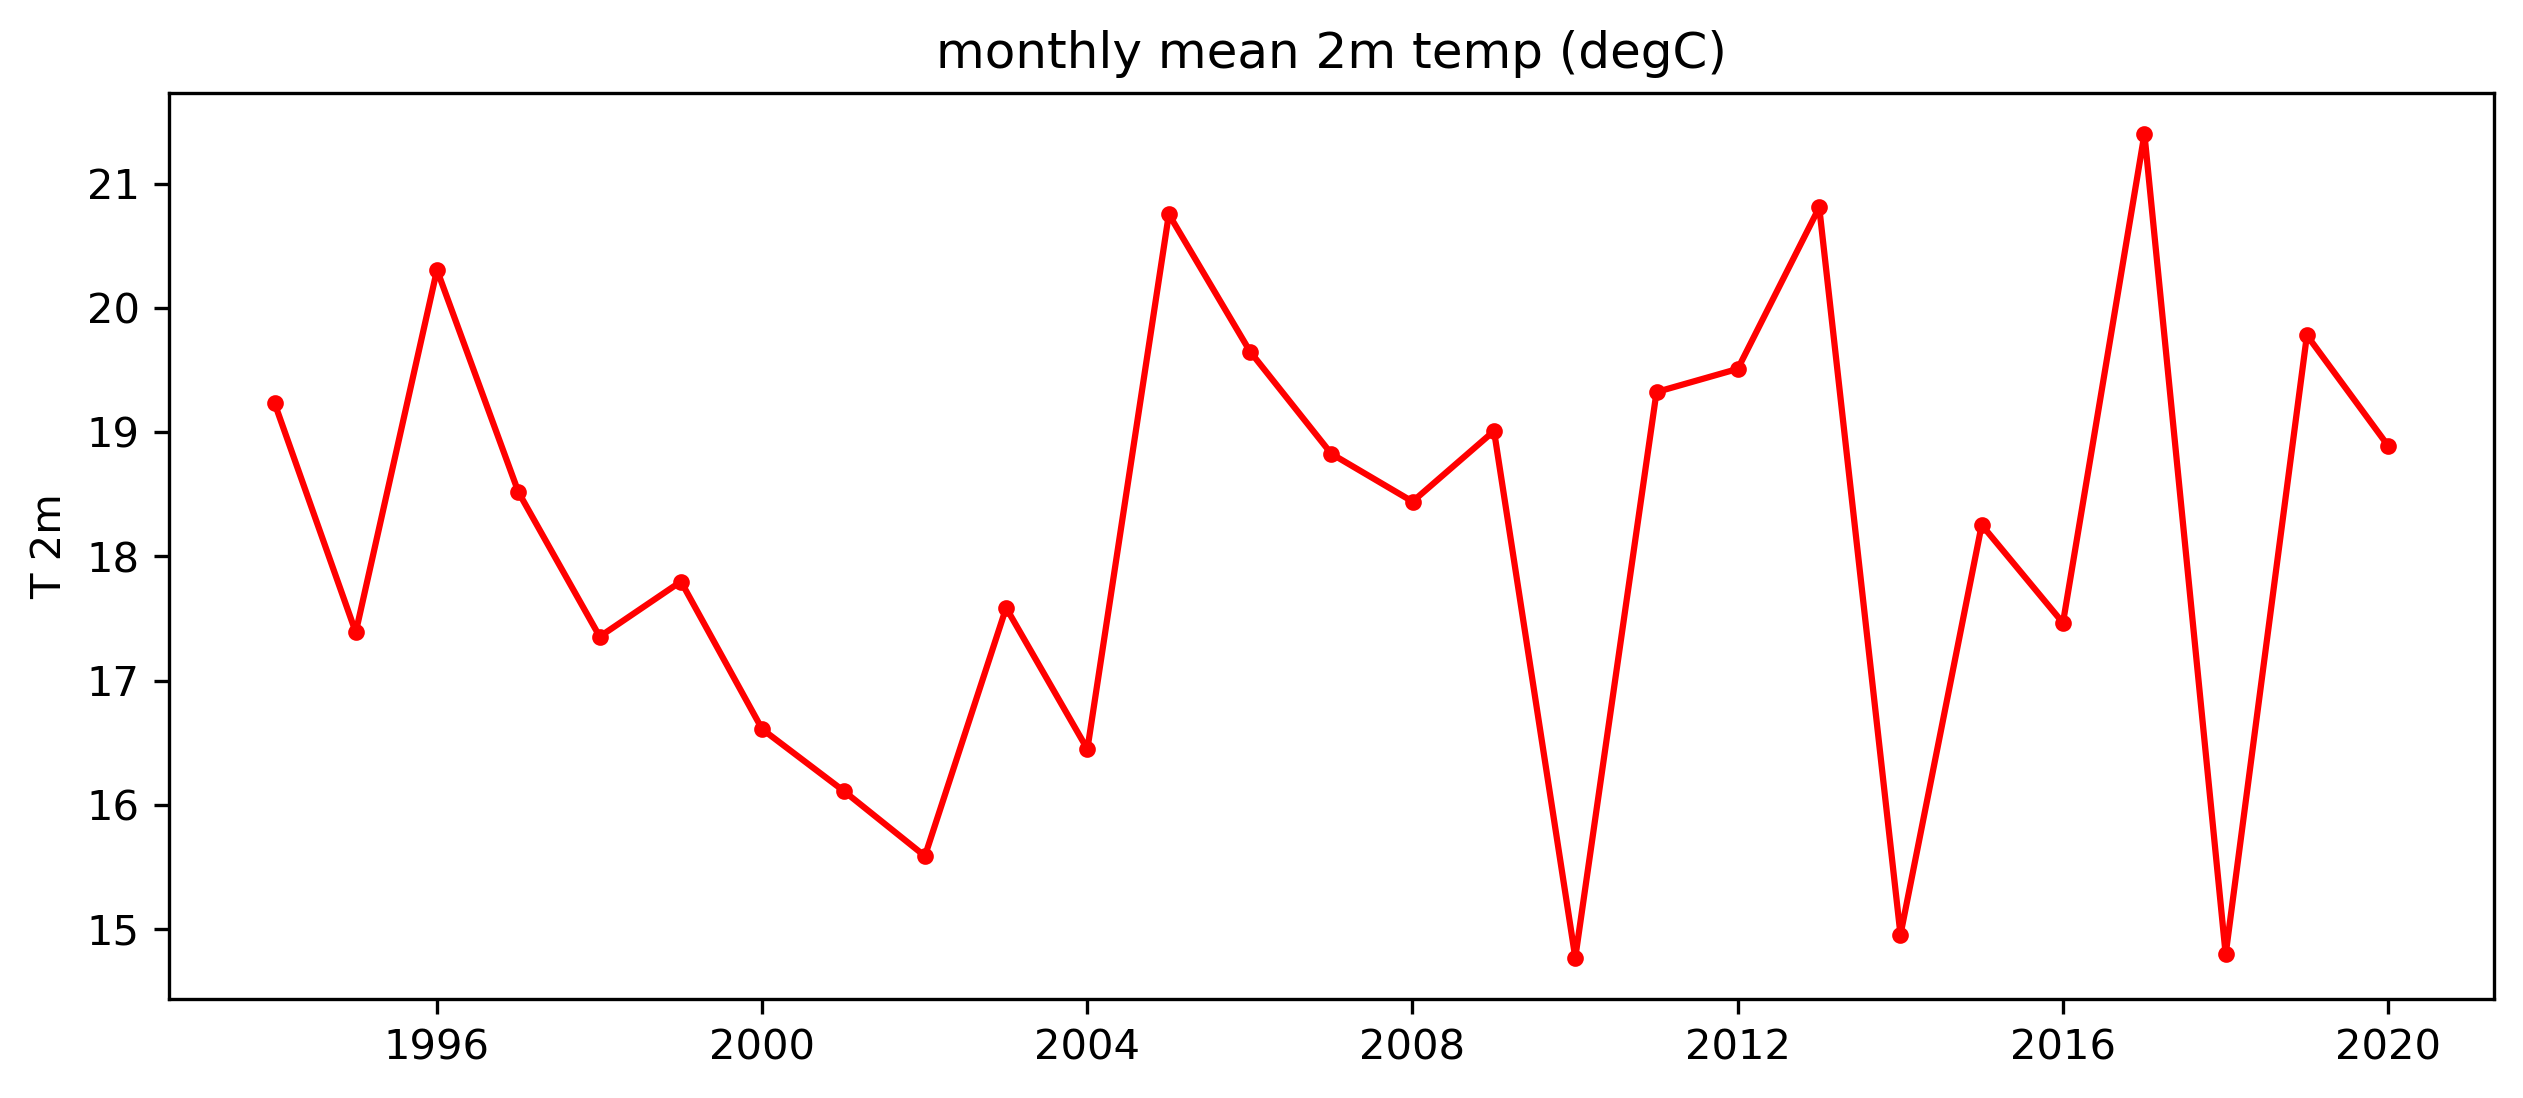

In [297]:
f, ((ax1 )) = plt.subplots(1, 1,figsize=(10,4), dpi=300,sharex =True)

plt.title("monthly mean 2m temp (degC)")

ax1.plot(dtime[::12],Yenisei_Aug, "r.-")
#ax1.plot(dtime[:-1],TempMean_Yukon[:-1], "g.-")
#ax1.plot(dtime[:-1],TempMean_Ob[:-1], "b.-")
#ax1.plot(dtime[:-1],TempMean_Mackenzie[:-1], "m.-")
#ax1.plot(dtime[:-1],TempMean_Lena[:-1], "c.-")
#ax1.plot(dtime[:-1],TempMean_Kolyma[:-1], "k.-")

plt.ylabel("T 2m")
plt.show()

In [294]:
Yenisei_June

[10.264224744537342,
 7.894438630198727,
 9.944145407729119,
 14.737108128333833,
 10.487378887909324,
 12.56175065259201,
 15.01712227397915,
 18.030034853872206,
 13.89614729160046,
 16.266077968870157,
 5.173696237714194,
 16.823627431077902,
 9.914935191949727,
 5.47262686807603,
 18.66723423925249,
 12.31633381783416,
 13.427363720924932,
 19.99205996185346,
 16.230600524843485,
 10.752860207130482,
 6.2653206932333285,
 12.130485414381885,
 13.66585003869291,
 11.16385687203342,
 9.73281991359997,
 9.323234863200486,
 11.689164548760075]

In [292]:
TempMean_Yenisei[13]

-19.41374565760729